# NI-VSM HW 3

Tým:

- Bittner Jan
- Bodnárová Radka
- Hošková Radka

In [0]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# HW settings
K = 16
L = len('Bittner')
X = ((K * L * 23) % 20) + 1
Y = ((X + ((K * 5 + L * 7) % 19)) % 20) + 1

x_file = str(X).zfill(3) + ".txt" # file name
x_file_content = open(f'../resources/{x_file}').readlines()[1:][0].replace(" ", "␣")  # file content
x_words = [len(x) for x in x_file_content.split("␣")] # words lengths array
x_words_len = len(x_words) # number of words
x_len = len(x_file_content) # content length
x_chars = Counter(x_file_content) # chars count

y_file = str(Y).zfill(3) + ".txt" # file name
y_file_content = open(f'../resources/{y_file}').readlines()[1:][0].replace(" ", "␣") # file content
y_words = [len(x) for x in y_file_content.split("␣")] # words lengths array
y_words_len = len(y_words) # number of words
y_len = len(y_file_content) # content length
y_chars = Counter(y_file_content) # chars count

## 1 - Za předpokladu výše odhadněte matici přechodu markovského řetězce pro první text. Pro odhad matice přechodu vizte přednášku 17. Odhadnuté pravděpodobnosti přechodu vhodně graficky znázorněte, např. použitím heatmapy.

<ipython-input-34-c4511e66319a-oGy5x5wXk5B233TWwVKphG>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  transition_matrix /= transition_matrix.sum(axis=1)[:, np.newaxis]


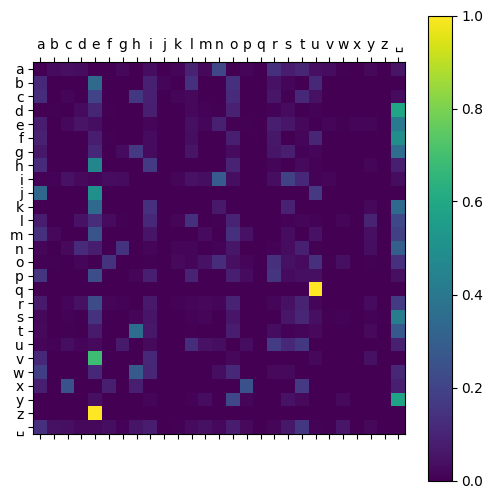

In [0]:
# Seznam posloupností znaků.
current_list = list(x_file_content)

# Seznam posloupností znaků posunut o 1.
next_list = list(x_file_content)
next_list.pop(0)
next_list.append(None)

# Dvojice.
bigrams = pd.DataFrame({'current': current_list, 'next': next_list, 'placeholder': 1}).head(-1)

# Matice přechodu.
transition_matrix = bigrams.pivot_table(index='current', columns='next', aggfunc='count').fillna(0).astype(int)
transition_matrix /= transition_matrix.sum(axis=1)[:, np.newaxis]

# Vykreslíme heatmapu.
plt.figure(figsize=(6, 6))
plt.matshow(transition_matrix, fignum=1)
plt.colorbar()
plt.xticks(range(transition_matrix.shape[1]), [x[1] for x in transition_matrix.columns])
plt.yticks(range(transition_matrix.shape[0]), transition_matrix.index)
plt.show()

## 2 - Na základě matice z předchozího bodu najděte stacionární rozdělení π tohoto řetězce pro první text.

In [0]:
# Získáme vlastní čísla a vektory.
eigen_values, eigen_vectors = np.linalg.eig(transition_matrix.T)

v = eigen_vectors[:, np.isclose(eigen_values, 1)]

# Normalizujeme.
pi = v.real.T/np.sum(v.real.T, 1)[:, np.newaxis]

In [0]:
print("Stacionární rozdělení π:\n", pi[0])

Stacionární rozdělení π:
 [6.66435043e-02 1.20765318e-02 2.01285818e-02 2.60973277e-02 9.79243081e-02 2.11684279e-02 1.62507628e-02 4.91468025e-02 5.69374305e-02 8.94572939e-04 6.55969618e-03 3.57848572e-02 2.13204089e-02 5.50182807e-02 6.42411380e-02 1.07353907e-02 7.45653782e-04 4.78590304e-02 5.51652482e-02 7.49894594e-02 2.72771550e-02 6.71057263e-03 1.68475208e-02 1.79107482e-03 1.83359592e-02 1.49090614e-04 1.89201213e-01]


In [0]:
# Je pi stacionární?
np.isclose(pi, pi @ transition_matrix).all()

True

## 3 - Porovnejte rozdělení znaků druhého textu se stacionárním rozdělením π, tj. na hladině významnosti 5 % otestujte hypotézu, že rozdělení znaků druhého textu se rovná rozdělení π z předchozího bodu.

Testujeme, zda se rozdělení znaků druhého textu rovná rozdělení stacionárního rozdělení π na hladině významnosti 5 %.
Použijeme $\chi^2$ test pro testování při známých parametrech.

$ H_0 $: Rozdělení znaků se rovná rozdělení π.

$ H_A $: Rozdělení znaků se **ne**rovná rozdělení π.

In [0]:
def get_charfreq(chars, char_len):
    charspst = {}
    for char in chars.keys():
        char_frequency = chars[char] / char_len
        charspst[char] = char_frequency
    return {k: charspst[k] for k in sorted(charspst.keys())}

y_charfreq = np.array(list(get_charfreq(y_chars, y_len).values()))

In [0]:
# Počet znaků s příliš malou četností.
print(sum(y_charfreq * y_len < 5))
print(sum(pi[0] * x_len < 5))

# Jejich indexy.
a, b = sorted(np.argsort(y_charfreq)[:2])
c, d = sorted(np.argsort(pi[0])[:2])
print(a, b)
print(c, d)

# Sloučení.
y_charfreq[b] += y_charfreq[a]
y_charfreq = np.delete(y_charfreq, a)

pix = pi[0]
pix[b] += pix[a]
pix = np.delete(pix, a)

1
1
16 25
16 25


Hodnoty frekvencí musí mít četnost alespoň 5, v opačném případě musíme sloučit nejméně frekventované znaky do jedné skupiny.
Jak bylo vypozorováno, máme jeden případ, kdy byla četnost 4, proto jsme ji sloučili s druhým nejmeně četným znakem.
Dohromady tato skupina již má větší četnost než 5.

---

Vizte z dokumentace chisquare funkce:

> This test is invalid when the observed or expected frequencies in each category are too small. A typical rule is that all of the observed and expected frequencies should be at least 5.

In [0]:
test_alpha = 0.05

chi2, pvalue = stats.chisquare(y_charfreq, pix)

print(f'test statistic χ² = {chi2:.4g}')
print(f'p-value = {pvalue:.4g}')
print(f'{pvalue > test_alpha}')

test statistic χ² = 0.02227
p-value = 1
True


Stanovily se hypotézy $H_0$ a $H_A$. Z provedených testů vidíme, že hodnota p-value je `1`. Z tohoto důvodu nulovou hypotézu nezamítáme.